### import libraries

In [1]:
from transformers import BridgeTowerProcessor, BridgeTowerForContrastiveLearning, BridgeTowerModel
import requests
from PIL import Image
from pathlib import Path
import os
from os import path as osp
import json
import cv2
import webvtt
import whisper
import torch
from moviepy.editor import VideoFileClip
from PIL import Image
from utils import getSubs, str2time, maintain_aspect_ratio_resize
from chromadb import Client
from chromadb.config import Settings
import base64
from utils import isBase64
from io import BytesIO

g:\conda_installation\envs\llm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Credentials

In [ ]:
HF_TOKEN = ""

### BridgeTower model

In [3]:
model_name = "BridgeTower/bridgetower-large-itm-mlm-itc"
bt_processor = BridgeTowerProcessor.from_pretrained(model_name, use_auth_token=HF_TOKEN)
bt_model = BridgeTowerForContrastiveLearning.from_pretrained(model_name, use_auth_token=HF_TOKEN)

Some weights of BridgeTowerForContrastiveLearning were not initialized from the model checkpoint at BridgeTower/bridgetower-large-itm-mlm-itc and are newly initialized: ['logit_scale']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
from PIL import Image
import torch

def create_dummy_image(size=(224, 224)):
    """Creates a blank white image to be used as a dummy input when no real image is provided."""
    return Image.new("RGB", size, (255, 255, 255))

class Embedder:
    def __init__(self, model, processor, device="cpu"):
        self.processor = processor
        self.model = model.to(device)
        self.device = device

    def get_embeddings(self, prompt, image=None):
        if image:
            image = Image.open(image)
        else:
            image = create_dummy_image()

        inputs = self.processor(images=[image], text=[prompt], padding=True, return_tensors="pt")
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)

        # Prefer cross_embeds if available, else fallback to text_embeds
        if image:
            embeddings = outputs.cross_embeds
        else:
            embeddings = outputs.text_embeds

        return embeddings.squeeze().tolist()

### Extract caption from video

#### extract audio

In [6]:
# Full path to the video file
path_to_video = "shared_data/videos/video1/Welcome back to planet earth.mp4"

# Extract the directory where the video is stored
video_dir = os.path.dirname(path_to_video)

# Define the output audio path
path_to_extracted_audio_file = os.path.join(video_dir, "audio.mp3")

# Load the video
clip = VideoFileClip(path_to_video)

# Extract and write the audio
clip.audio.write_audiofile(path_to_extracted_audio_file)

MoviePy - Writing audio in shared_data/videos/video1\audio.mp3


MoviePy - Done.


#### generate captions of the video using whisper

In [7]:
model = whisper.load_model("small")
options = dict(task="translate", best_of=1, language='en')
results = model.transcribe(path_to_extracted_audio_file, **options)

#### generate .vtt file for the video

In [8]:
vtt = getSubs(results["segments"], "vtt")
vid1_dir = "shared_data/videos/video1"
# path to save generated transcript of video1
path_to_generated_trans = osp.join(vid1_dir, 'generated_video1.vtt')
# write transcription to file
with open(path_to_generated_trans, 'w') as f:
    f.write(vtt)

In [9]:
with open(path_to_generated_trans, 'r', encoding='utf-8') as f:
    for i in range(15):
        print(f.readline().strip())

WEBVTT

00:00.000 --> 00:08.780
As I look back on the mission that we've had here on the International Space Station,

00:08.780 --> 00:13.300
I'm proud to have been a part of much of the science activities that happened over the

00:13.300 --> 00:14.300
last two months.

00:14.300 --> 00:16.180
The view is always amazing though.

00:16.180 --> 00:21.260


### preprocess video

#### extract_and_save_frames_and_metadata

In [10]:
# function `extract_and_save_frames_and_metadata``:
#   receives as input a video and its transcript
#   does extracting and saving frames and their metadatas
#   returns the extracted metadatas
def extract_and_save_frames_and_metadata(
        path_to_video, 
        path_to_transcript, 
        path_to_save_extracted_frames,
        path_to_save_metadatas):
    
    # metadatas will store the metadata of all extracted frames
    metadatas = []

    # load video using cv2
    video = cv2.VideoCapture(path_to_video)
    # load transcript using webvtt
    trans = webvtt.read(path_to_transcript)
    
    # iterate transcript file
    # for each video segment specified in the transcript file
    for idx, transcript in enumerate(trans):
        # get the start time and end time in seconds
        start_time_ms = str2time(transcript.start)
        end_time_ms = str2time(transcript.end)
        # get the time in ms exactly 
        # in the middle of start time and end time
        mid_time_ms = (end_time_ms + start_time_ms) / 2
        # get the transcript, remove the next-line symbol
        text = transcript.text.replace("\n", ' ')
        # get frame at the middle time
        video.set(cv2.CAP_PROP_POS_MSEC, mid_time_ms)
        success, frame = video.read()
        if success:
            # if the frame is extracted successfully, resize it
            image = maintain_aspect_ratio_resize(frame, height=350)
            # save frame as JPEG file
            img_fname = f'frame_{idx}.jpg'
            img_fpath = osp.join(
                path_to_save_extracted_frames, img_fname
            )
            cv2.imwrite(img_fpath, image)

            # prepare the metadata
            metadata = {
                'extracted_frame_path': img_fpath,
                'transcript': text,
                'video_segment_id': idx,
                'video_path': path_to_video,
                'mid_time_ms': mid_time_ms,
            }
            metadatas.append(metadata)

        else:
            print(f"ERROR! Cannot extract frame: idx = {idx}")

    # save metadata of all extracted frames
    fn = osp.join(path_to_save_metadatas, 'metadatas.json')
    with open(fn, 'w') as outfile:
        json.dump(metadatas, outfile)
    return metadatas

In [11]:
# output paths to save extracted frames and their metadata 
extracted_frames_path = osp.join(vid1_dir, 'extracted_frame')
metadatas_path = vid1_dir

# create these output folders if not existing
Path(extracted_frames_path).mkdir(parents=True, exist_ok=True)
Path(metadatas_path).mkdir(parents=True, exist_ok=True)

# call the function to extract frames and metadatas
metadatas = extract_and_save_frames_and_metadata(
                path_to_video, 
                path_to_generated_trans,
                extracted_frames_path,
                metadatas_path,
            )
              

Generated caption is: " I'm proud to have been a part of much of the science activities that happened over the"


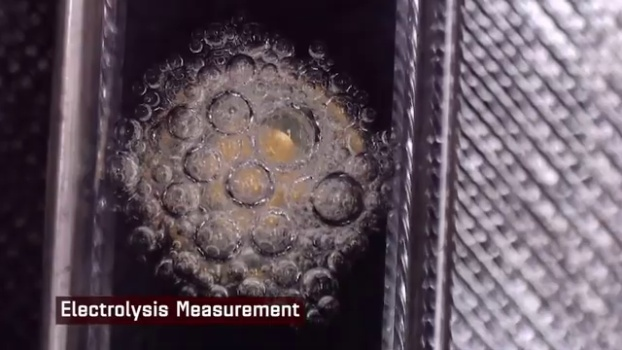

In [12]:
data = metadatas[1]
caption = data['transcript']
print(f'Generated caption is: "{caption}"')
frame = Image.open(data['extracted_frame_path'])
display(frame)

#### overlap the transcripts of n neighboring frames for better context

In [13]:
# load metadata files
vid1_metadata_path = './shared_data/videos/video1/metadatas.json'
with open(vid1_metadata_path, 'r') as file:
    vid1_metadata = json.load(file)

# collect transcripts and image paths
vid1_trans = [vid['transcript'] for vid in vid1_metadata]
vid1_img_path = [vid['extracted_frame_path'] for vid in vid1_metadata]

n = 7
updated_vid1_trans = [
 ' '.join(vid1_trans[i-int(n/2) : i+int(n/2)]) if i-int(n/2) >= 0 else
 ' '.join(vid1_trans[0 : i + int(n/2)]) for i in range(len(vid1_trans))
]

# also need to update the updated transcripts in metadata
for i in range(len(updated_vid1_trans)):
    vid1_metadata[i]['transcript'] = updated_vid1_trans[i]

Generated caption is: " As I look back on the mission that we've had here on the International Space Station,  I'm proud to have been a part of much of the science activities that happened over the  last two months.  The view is always amazing though."
1


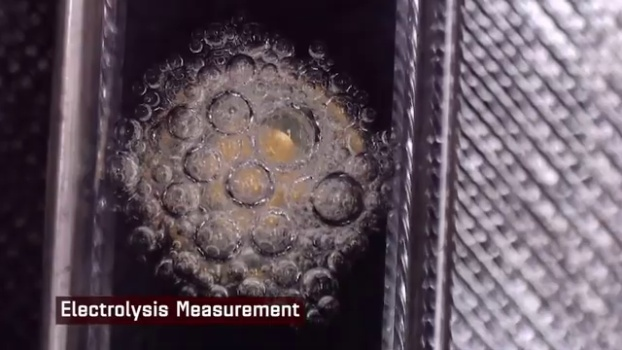

In [14]:
data = vid1_metadata[1]
caption = data['transcript']
print(f'Generated caption is: "{caption}"')
print(data['video_segment_id'])
frame = Image.open(data['extracted_frame_path'])
display(frame)

### Populate ChromaDB with the embeddings

In [15]:
# Initialize ChromaDB
client = Client(Settings(persist_directory="shared_data/chromadb_data"))
collection = client.get_or_create_collection(name="my_bt_collection")

# Generate embeddings
documents = []
metadatas = []
ids = []
embeddings = []

embedder = Embedder(bt_model, bt_processor, device=device)

for item in vid1_metadata:
    embedding = embedder.get_embeddings(item["transcript"], item["extracted_frame_path"])
    
    documents.append(item["transcript"])
    metadatas.append({"image_path": item["extracted_frame_path"]}),
    ids.append(f"item_{item['video_segment_id']}"),
    embeddings.append(embedding)

# Add to ChromaDB
collection.add(
    documents=documents,
    metadatas=metadatas,
    ids=ids,
    embeddings=embeddings
)


 As I look back on the mission that we've had here on the International Space Station,  I'm proud to have been a part of much of the science activities that happened over the  last two months.
item_0


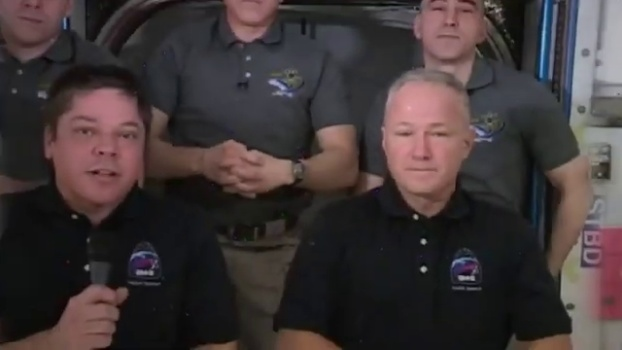

-------------------------------------------------
 Welcome back to Planet Earth and thanks for flying SpaceX.  It's truly our honor and privilege.  Space dads are back on Earth after a 19-hour return journey from space.  You
item_22


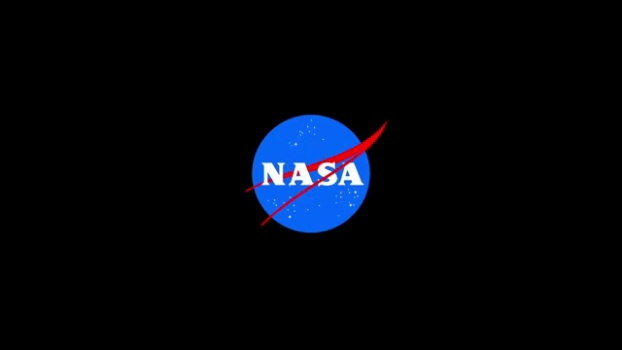

-------------------------------------------------
 I'm proud to have been a part of much of the science activities that happened over the  last two months.  The view is always amazing though.  I didn't think I would do another spacewalk and to now have the chance to have done four  more was just icing on the cake for a wonderful mission.  The tenth one, do you like the first one?
item_4


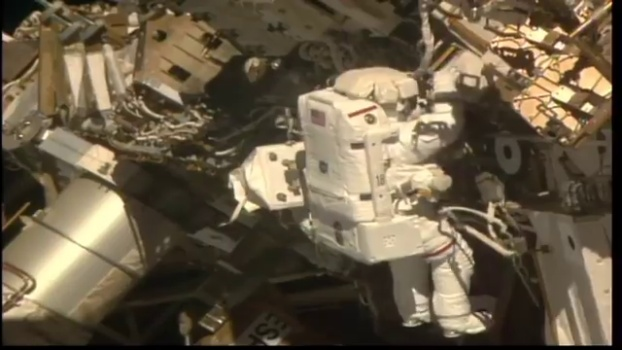

-------------------------------------------------
 As I look back on the mission that we've had here on the International Space Station,  I'm proud to have been a part of much of the science activities that happened over the  last two months.  The view is always amazing though.  I didn't think I would do another spacewalk and to now have the chance to have done four
item_2


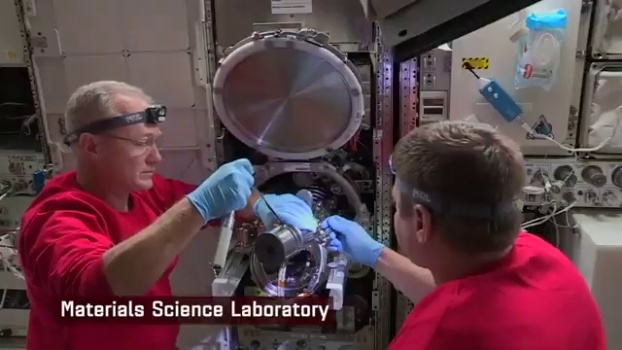

-------------------------------------------------
 last two months.  The view is always amazing though.  I didn't think I would do another spacewalk and to now have the chance to have done four  more was just icing on the cake for a wonderful mission.  The tenth one, do you like the first one?  No.
item_5


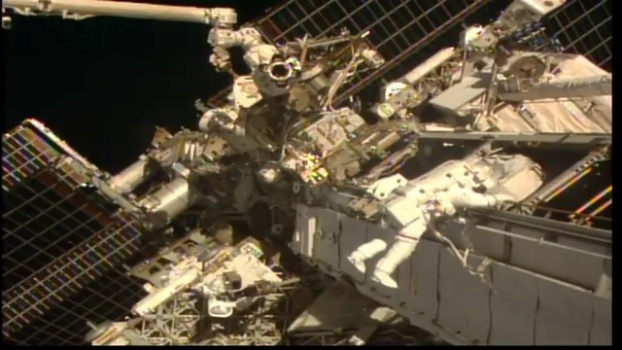

-------------------------------------------------


In [17]:
query_text = ("a group astronaut talking about their mission")
query_embedding = embedder.get_embeddings(query_text)  # No image → uses dummy image

results = collection.query(
    query_embeddings=[query_embedding],
    n_results=5,
    include=["documents", "metadatas"]
)

for i in range(5):
    print(results["documents"][0][i])
    print(results["ids"][0][i])
    display(Image.open(results["metadatas"][0][i]["image_path"]))
    print("-------------------------------------------------")